# 2 Kernelized Ridge Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [2]:
def K(X1, X2, h):
    return np.exp(
        -(np.linalg.norm(X1 - X2, axis=-1)**2) / (2*h**2)
    )

## Kernelized Ridge Regression

In [3]:
def fit_ridge(X, y, h, t):
    # Use a generator to prevent memory overflow
    def generate_G():
        for X1 in X:
            yield K(X1, X, h)
    
    G = np.stack(
        generate_G()
    )    
    
    # Faster than actually computing inverse
    alpha = np.linalg.solve((G + t*np.eye(G.shape[0])).T, y)

    return alpha

In [4]:
def predict_ridge(X_new, X, alpha, h):
    # Use a generator to prevent memory overflow
    def generate_y():
        for X1 in X_new:
            k = K(X1, X, h)
            yield np.dot(alpha, k)
    
    return np.fromiter(
        generate_y(),
        dtype=np.float128,
        count=X_new.shape[0]
    )

In [5]:
def reconstruct_ridge(image, h, t):
    
    image_ = np.copy(image)
    
    mask = image_ != 0
    
    X = np.argwhere(mask)
    y = image_[mask]
    
    X_new = np.argwhere(np.logical_not(mask))
    
    alpha = fit_ridge(X, y, h, t)
    
    y_new = predict_ridge(X_new, X, alpha, h)
    
    image_[np.logical_not(mask)] = y_new
    
    return image_

## Nadaraya-Watson Kernel Regression

In [6]:
def predict_nw(X_new, X, y, h):
    # Use a generator to prevent memory overflow
    def generate_y():
        for X1 in X_new:
            k = K(X1, X, h)
            yield np.sum(y*k)/np.sum(k)
            
    return np.fromiter(
        generate_y(),
        dtype=np.float128,
        count=X_new.shape[0]
    )

In [7]:
def reconstruct_nw(image, h, t):
    
    image_ = np.copy(image)
    
    mask = image_ != 0
    
    X = np.argwhere(mask)
    y = image_[mask]
    
    X_new = np.argwhere(np.logical_not(mask))
    
    y_new = predict_nw(X_new, X, y, h)
    
    image_[np.logical_not(mask)] = y_new
    
    return image_

In [11]:
image = imageio.imread("./cc_90.png")

h = 6
t = 0.1
reconstructed_ridge = reconstruct_ridge(image, h, t)

In [12]:
reconstructed_nw = reconstruct_nw(image, h, t)

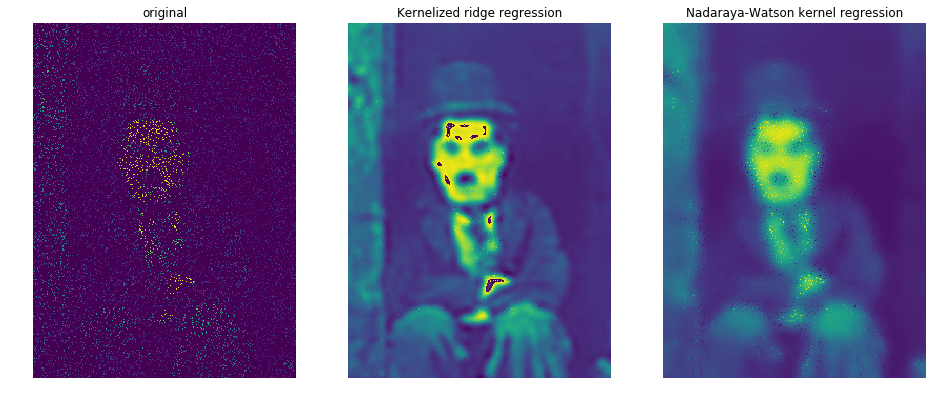

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,8))
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('original')
ax2.imshow(reconstructed_ridge)
ax2.axis('off')
ax2.set_title('Kernelized ridge regression')
ax3.imshow(reconstructed_nw)
ax3.axis('off')
ax3.set_title('Nadaraya-Watson kernel regression')
plt.show()